In [1]:
%load_ext autoreload
%autoreload 2

## Counting occurrences

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

tqdm.pandas()

In [70]:


# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_series(text_series):
    """
    Cleans a Pandas Series of text data:
    - Removes links, punctuation
    - Tokenizes text
    - Converts to lowercase
    - Removes stopwords
    - Lemmatizes words
    """
    # Remove links
    text_series = text_series.str.replace(r"http\S+|www\S+|https\S+", '', regex=True)
    
    # Tokenize text into words
    tokenized = text_series.apply(nltk.word_tokenize)
    
    # Convert to lowercase and filter out non-alphabetic words
    tokenized = tokenized.apply(lambda tokens: [word.lower() for word in tokens if word.isalpha()])
    
    # Remove stopwords
    tokenized = tokenized.apply(lambda tokens: [word for word in tokens if word not in stop_words])
    
    # Lemmatize words
    tokenized = tokenized.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
    
    return tokenized

def keyword_occurrence_matrix(sentences, keywords):
    """
    Generates a keyword occurrence matrix for a list of sentences and keywords.
    """
    # Convert sentences and keywords into Pandas Series
    sentences_series = pd.Series(sentences)
    keywords_series = pd.Series(keywords)
    
    # Clean sentences and keywords
    clean_sentences = clean_text_series(sentences_series)
    clean_keywords = clean_text_series(keywords_series)
    
    # Flatten the keywords into a unique set
    keywords_set = set(np.concatenate(clean_keywords.to_numpy()))
    
    # Initialize the DataFrame
    occurrence_matrix = pd.DataFrame(0, index=range(len(sentences)), columns=list(keywords_set))
    
    # Fill the matrix with keyword occurrences
    for i, tokens in enumerate(clean_sentences):
        for keyword in keywords_set:
            occurrence_matrix.loc[i, keyword] = tokens.count(keyword)
    
    return occurrence_matrix.sum(axis = 0)


[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
keywords = ['goal', 'card', "half time", "kick-off", "full time", "penalty"]

In [72]:
def get_first_texts(x, min_size = 10):
    return keyword_occurrence_matrix(x, keywords)

In [73]:
train_indices = [0,2,4,7]
val_indices = [8,11,13]
train_data, test_data = train_test_split()

def get_samples(indices, frac = 1):
    all_df = []
    for id in indices:
        temp_df = train_data[id]
        # for i in range(1,5+1):  
        #     temp_df[f"Tweet"] = temp_df['Tweet'].shift(i) + temp_df['Tweet']
        
        all_df.append(temp_df.dropna().sample(frac=frac))

        
    return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({
        "Tweet":    get_first_texts,
        "EventType": np.mean,
        "ID": len
    })

train_df = get_samples(train_indices)
# val_df = get_samples(val_indices)

100%|██████████| 16/16 [00:09<00:00,  1.78it/s]
/tmp/ipykernel_2309136/3203128290.py:15: FutureWarning: The provided callable <function mean at 0x7fb93c16dbc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({


In [79]:
train_df['s'] = train_df['Tweet'].apply(lambda x : x.sum())

In [89]:
X = np.stack(train_df['Tweet'].to_numpy())

In [96]:
y = train_df['EventType'].to_numpy().reshape(-1,1)

In [97]:
y

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],

In [102]:
val_df = get_samples(val_indices)

/tmp/ipykernel_2309136/3203128290.py:15: FutureWarning: The provided callable <function mean at 0x7fb93c16dbc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({


In [104]:
X_test = np.stack(val_df['Tweet'].to_numpy())
y_test = val_df['EventType'].to_numpy().reshape(-1,1)

In [110]:
clf = RandomForestClassifier(max_depth = 1)
clf.fit(X, y)
y_pred = clf.predict(X)

/users/eleves-a/2022/pedro.silva/Desktop/pay_attention_to_what_matters/.conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [111]:
y_pred_test = clf.predict(X_test)

In [112]:
accuracy_score(y_test, y_pred_test)

0.6358974358974359

In [101]:
accuracy_score(y, y_pred)

0.7767857142857143

<Axes: xlabel='s', ylabel='Density'>

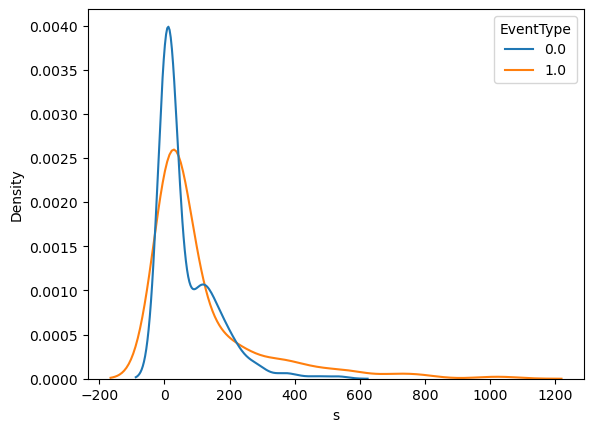

In [82]:
sns.kdeplot(train_df, hue = 'EventType', x = 's')

In [7]:
train_df.iloc[0,0]

array([list(['honduras', 'v', 'switzerland', 'team', 'announcement', 'substitute', 'formation', 'honduras', 'v', 'switzerland']),
       list(['catch', 'action', 'hon', 'v', 'sui', 'live', 'goal']),
       list(['honduras', 'game', 'seem', 'exciting', 'france', 'ecuador', 'though']),
       list(['honduras', 'v', 'switzerland', 'switzerland', 'win', 'half', 'coral', 'special', 'bet']),
       list(['honduras', 'v', 'switzerland', 'switzerland', 'win', 'half', 'coral', 'special', 'bet']),
       list(['live', 'honduras', 'v', 'switzerland', 'text', 'commentary', 'goal', 'hon', 'che', 'worldcup']),
       list(['match', 'update', 'world', 'cup', 'group', 'e', 'honduras', 'line', 'valladares', 'figueroa', 'bernardez', 'j', 'garcia', 'w', 'palacios']),
       list(['let', 'go', 'ecuador', 'let', 'go', 'honduras']),
       list(['honduras', 'v', 'swiss']), list(['honduras', 'v', 'swiss']),
       list(['honduras', 'v', 'ecuador', 'current', 'tweet', 'live', 'dashboard', 'tweetwars']),
     